In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

In [3]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install -U nltk -qq
    !pip install -U spacy -qq
    !pip install -U pyspellchecker -qq
    !python -m spacy download en_core_web_sm -qq
    !python -m spacy download en_core_web_lg -qq

    basepath = '/content/drive/MyDrive/data'
    sys.path.append('/content/drive/MyDrive/Colab Notebooks/NLP UTD')
else:
    basepath = '/home/harpreet/Insync/google_drive_shaannoor/data'
    sys.path.append(
    '/home/harpreet/Insync/google_drive_shaannoor/data/custom-functions')


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 72.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart ru

### Libraries

In [4]:
import numpy as np
import pandas as pd

In [5]:
from pathlib import Path

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from CustomPreprocessorSpacy import SpacyPreprocessor as preprocessor
from FeaturizerSpacy import ManualFeatures as featurize
from plot_learning_curve import *

from sklearn.base import TransformerMixin, BaseEstimator

from spellchecker import SpellChecker
from scipy.sparse import csr_matrix
import re, os

In [6]:
data_loc=Path(basepath)/"datasets"/"spam.csv"
spam_data = pd.read_csv(data_loc, encoding="ISO-8859-1")

In [7]:
spam_data.dropna(axis=1, inplace=True)
spam_data.rename(columns={"v1":"label","v2":"message"},inplace=True)
spam_data['label'].replace({"ham":0,"spam":1},inplace=True)


In [8]:
spam_large = spam_data.sample(frac=0.57, replace=True, random_state=1)

In [9]:
(spam_large['label'].value_counts()/len(spam_large)) * 100

,count
label,
0,87.342569
1,12.657431


In [10]:
X_train = spam_large['message'].values
y_train = spam_large['label'].values

## Training our selected Pipeline i.e Pipeline 3 on the above computed set.

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import StratifiedKFold
cv_kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

Feature Extractor

In [12]:
class CustomFeatures(featurize):
  def __init__(self,spacy_model, batch_size = 64, pos_features = True, ner_features = True, text_descriptive_features = True, wrong_spelling_features = True, all_caps_and_characters=True, num_urls_feature = True):
    self.spacy_model = spacy_model
    self.batch_size = batch_size
    self.pos_features = pos_features
    self.ner_features = ner_features
    self.text_descriptive_features = text_descriptive_features
    self.wrong_spelling_features = wrong_spelling_features
    self.all_caps_and_characters = all_caps_and_characters
    self.num_urls_feature = num_urls_feature

  def spelling_errors(self, cleaned_text):

    list_count_spell_errors=[]
    spell = SpellChecker()

    for text in cleaned_text:
      mistakes = spell.unknown(text.split())
      list_count_spell_errors.append(len(mistakes))
    spelling_mistakes_features = np.vstack((list_count_spell_errors))
    return spelling_mistakes_features


  def all_caps_count(self, cleaned_text):

    list_all_caps = []
    list_excl_marks = []
    list_ques_marks = []


    for text in cleaned_text:
      all_caps_words = re.findall(r'\b[A-Z][A-Z]+\b', text)
      list_all_caps.append(len(all_caps_words))

      multiple_exclamation_marks = re.findall(r'!{3,}', text)
      list_excl_marks.append(len(multiple_exclamation_marks))

      multiple_question_marks = re.findall(r'\?{3,}', text)
      list_ques_marks.append(len(multiple_question_marks))

    unusual_text_features = np.vstack((list_all_caps,list_excl_marks,list_ques_marks))
    return np.transpose(unusual_text_features)

  def number_of_urls(self, cleaned_text):

    list_num_urls = []

    url_pattern = re.compile(
        r'(https?://[^\s/$.?#].[^\s]*|www\.[^\s/$.?#].[^\s]*)',
        re.IGNORECASE
    )

    for text in cleaned_text:
      urls = url_pattern.findall(text)
      list_num_urls.append(len(urls))

    url_features = np.vstack((list_num_urls))
    return url_features

  def transform(self, X, y=None):

        try:
            # Check if the input data is a list or numpy array
            if not isinstance(X, (list, np.ndarray)):
                raise TypeError(f"Expected list or numpy array, got {type(X)}")


            feature_names = []

            if self.text_descriptive_features:
                text_descriptive_features = self.get_text_descriptive_features(X)
                feature_names.extend(['count_words', 'count_characters',
                                      'count_characters_no_space', 'avg_word_length',
                                      'count_numbers', 'count_sentences'])
            else:
                text_descriptive_features = np.empty(shape=(0, 0))

            if self.pos_features:
                pos_features = self.get_pos_features(X)

                feature_names.extend(['noun_count', 'aux_count', 'verb_count', 'adj_count'])
            else:
                pos_features = np.empty(shape=(0, 0))

            if self.ner_features:
                ner_features = self.get_ner_features(X)

                feature_names.extend(['ner'])
            else:
                ner_features = np.empty(shape=(0, 0))

            if self.all_caps_and_characters:
              unusual_features = self.all_caps_count(X)
              feature_names.extend(['caps_count','excl_count','ques_count'])
            else:
              unusual_features = np.empty(shape=(0,0))

            if self.num_urls_feature:
              url_feature = self.number_of_urls(X)
              feature_names.extend(['urls_count'])
            else:
              url_feature = np.empty(shape=(0,0))

            if self.wrong_spelling_features:
              spelling_mistakes_features = self.spelling_errors(X)
              feature_names.extend(['spelling_errors_count'])
            else:
              spelling_mistakes_features = np.empty(shape=(0,0))

            # Stack the feature arrays horizontally to form a single 2D numpy array
            return np.hstack((text_descriptive_features, pos_features,  ner_features, unusual_features, url_feature, spelling_mistakes_features)), feature_names

        except Exception as error:
            print(f'An exception occured: {repr(error)}')

In [13]:
featurizer = CustomFeatures(spacy_model='en_core_web_lg', batch_size = 1000)
X_train_features, feature_names = featurizer.fit_transform(X_train)

In [14]:
X_train_real = pd.concat((pd.DataFrame(X_train, columns=['text_c']),
                           pd.DataFrame(X_train_features, columns=feature_names)), axis=1)

In [15]:
X_train_real.head(1)

,text_c,count_words,count_characters,count_characters_no_space,avg_word_length,count_numbers,count_sentences,noun_count,aux_count,verb_count,adj_count,ner,caps_count,excl_count,ques_count,urls_count,spelling_errors_count
0,K k:) sms chat with me.,6.0,23.0,18.0,2.571429,0.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [16]:
class SparseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return csr_matrix(X)

In [17]:
sparse_features = Pipeline([('sparse', SparseTransformer()), ])
vectorizer = Pipeline([('tfidf', TfidfVectorizer(encoding='latin-1',stop_words='english',strip_accents='unicode')), ])

In [19]:
combined_features = ColumnTransformer(
    transformers=[
        ('tfidf', vectorizer, 'text_c'),
    ], remainder=sparse_features
)

In [21]:
pipeline = Pipeline([('combined_features',  combined_features),
                         ('classifier', MultinomialNB()),
                         ])

In [22]:
param_grid = {'combined_features__tfidf__tfidf__max_features': [1000, 2000, 5000, 8000, 10000],
                           'classifier__alpha': [0.001, 0.01, 0.1, 0.5, 1.0]
                           }

In [23]:
random_search_clf = HalvingRandomSearchCV(estimator=pipeline, param_distributions = param_grid, cv=cv_kfold, scoring='f1_weighted', random_state=1)

In [25]:
random_search_clf.fit(X_train_real, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 25 is smaller than n_iter=158. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


HalvingRandomSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                      estimator=Pipeline(steps=[('combined_features',
                                                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                              SparseTransformer())]),
                                                                   transformers=[('tfidf',
                                                                                  Pipeline(steps=[('tfidf',
                                                                                                   TfidfVectorizer(encoding='latin-1',
                                                                                                                   stop_words='english',
                                                                                                                   strip_accents='unicode'))]),
                                                                                  'text_c')])),
                                                ('classifier',
                                                 MultinomialNB())]),
                      param_distributions={'classifier__alpha': [0.001, 0.01,
                                                                 0.1, 0.5,
                                                                 1.0],
                                           'combined_features__tfidf__tfidf__max_features': [1000,
                                                                                             2000,
                                                                                             5000,
                                                                                             8000,
                                                                                             10000]},
                      random_state=1, scoring='f1_weighted')

In [26]:
print(f'Best cross-validation score: {random_search_clf.best_score_:.2f}')
print("\nBest parameters: ", random_search_clf.best_params_)
print("\nBest estimator: ", random_search_clf.best_estimator_)

Best cross-validation score: 0.96

Best parameters:  {'combined_features__tfidf__tfidf__max_features': 5000, 'classifier__alpha': 0.01}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(encoding='latin-1',
                                                                                   max_features=5000,
                                                                                   stop_words='english',
                                                                                   strip_accents='unicode'))]),
                                                  'text_c')])),
                ('classifier'

#### Plotting CV Results and how this pipeline has fared

---

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

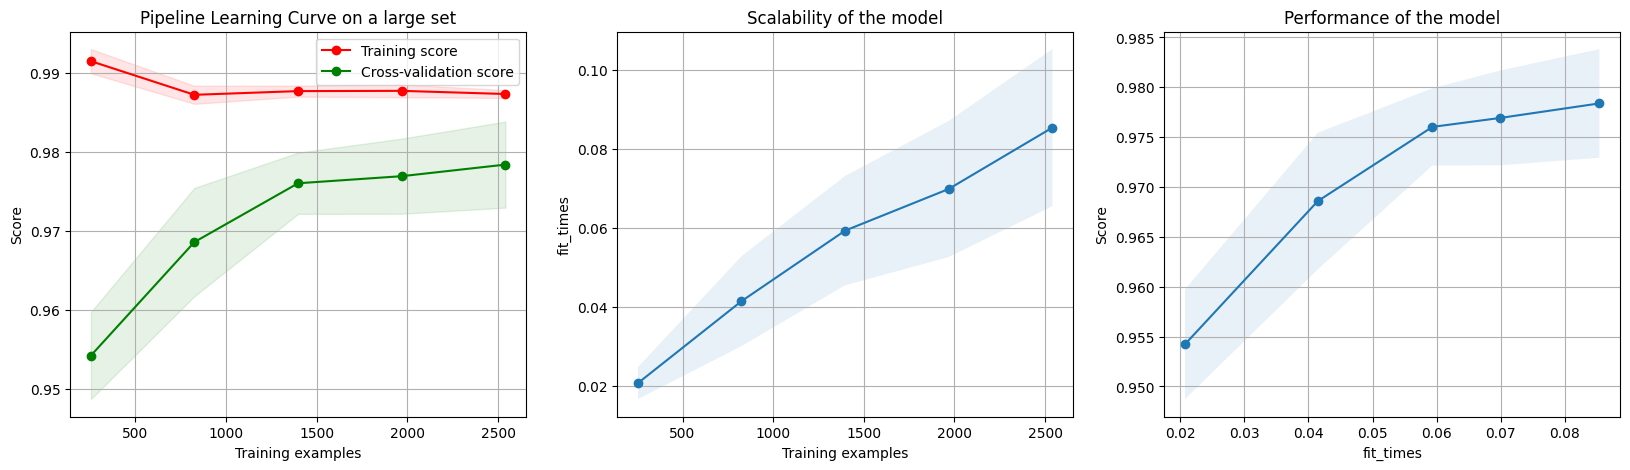

In [27]:
plot_learning_curve(estimator = random_search_clf.best_estimator_, title = 'Pipeline Learning Curve on a large set',X=X_train_real, y=y_train,cv=cv_kfold, scoring='f1_weighted')